In [21]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd() + "/livrable_2"

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

encoding_dim = 256

Deleting /tf/ProjetDeepLearning/livrable_2/data/validation/unsorted
Deleting /tf/ProjetDeepLearning/livrable_2/data/validation/sorted


In [23]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) == 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
# Call the function
download_dataset()

Dataset is already downloaded.
Dataset is already extracted.


In [24]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))  # You can specify extensions like '*.jpg' if necessary

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

# Call the function to check the images in the train data path
#check_images_in_dataset(paths['train_data_path'])


In [25]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

Found 758 files.
Using 607 files for training.
Using 151 files for validation.


Remarque sympa de notre ami le chat : 

Distribution du bruit : Si tu souhaites tester d'autres types de bruit, tu pourrais explorer différentes distributions (par exemple du bruit impulsionnel ou du bruit Poisson) en plus du bruit gaussien pour diversifier encore plus les perturbations appliquées aux images.

In [26]:
# Ajout de la couche de redimensionnement
rescale_layer = tf.keras.layers.Rescaling(1./255)


def add_gaussian_noise(images, min_noise=0.1, max_noise=0.4):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

# Création des datasets avec bruit
noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


noisy_test_set = test_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2024-10-22 08:55:18.113681: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-22 08:55:18.159271: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


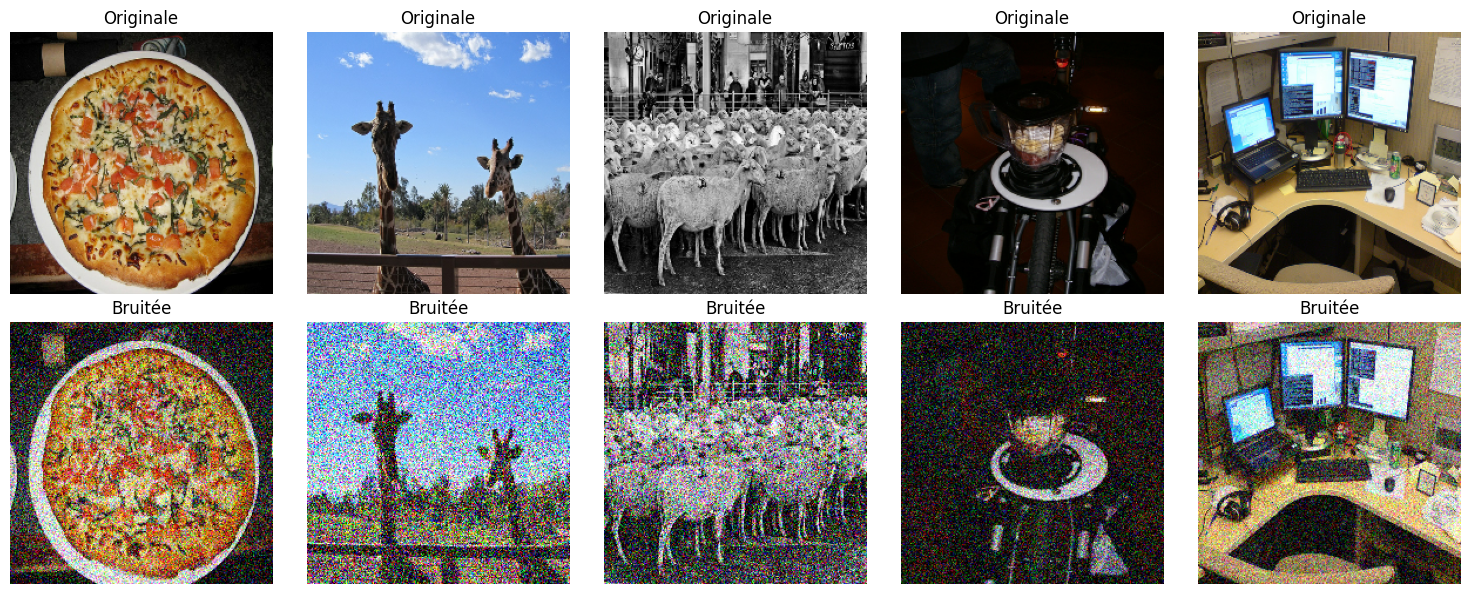

2024-10-22 08:55:18.658777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


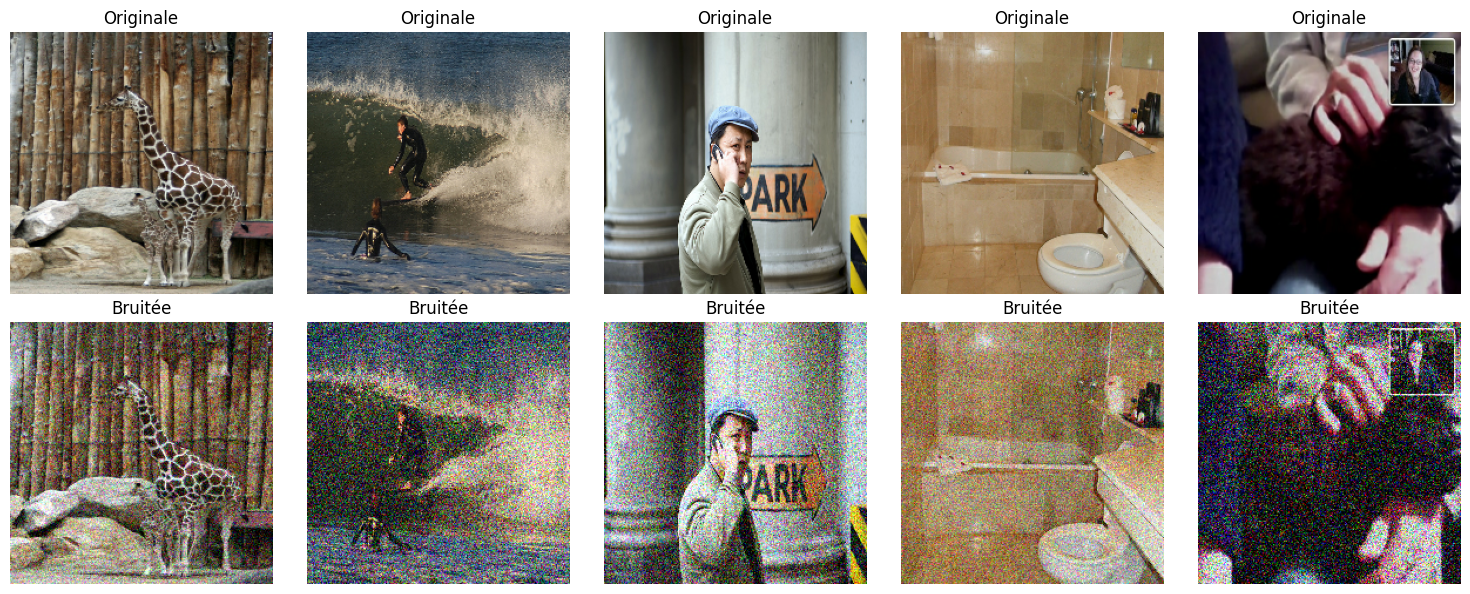

In [27]:
# Fonction pour afficher les images originales et bruitées
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Image originale
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')

            # Image bruitée
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)
display_noisy_train_images(noisy_test_set, num_images=5)

In [28]:
def build_autoencoder(input_shape):
    input_img = tf.keras.layers.Input(shape=input_shape)
    
    # **Encoder**
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # **Decoder**
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # **Self-encoding model**
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

# **Model construction**
input_shape = (image_h, image_w, 3)
autoencoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
def get_callbacks():
    # Create a callback that saves the model's weights at each epoch where validation loss improves
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Create a TensorBoard callback to log training metrics, model graphs, and images for visualization
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )

    # Set up early stopping to halt training if validation loss stops improving for a set number of epochs
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=25,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    )

    return [
        checkpoint_callback,
        tensorboard_callback,
        early_callback
    ]

# **Entraînement du modèle**
history = autoencoder.fit(
    noisy_train_set,
    epochs=150,
    validation_data=noisy_test_set,
    callbacks=get_callbacks()
)

autoencoder.save(f"{paths['model_path']}/autoencoder.h5")


Epoch 1/150


I0000 00:00:1729587320.792933    6193 service.cc:146] XLA service 0x7f1240003ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729587320.792957    6193 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-22 08:55:20.861338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 08:55:21.179121: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 1/19 ━━━━━━━━━━━━━━━━━━━━ 4:03 14s/step - loss: 28.9683

I0000 00:00:1729587332.827800    6193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - loss: 27.4227
Epoch 1: val_loss improved from inf to 19.54624, saving model to /tf/ProjetDeepLearning/livrable_2/weights/model_early/weights-epoch-01-19.55.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 827ms/step - loss: 27.3298 - val_loss: 19.5462
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 20.5671
Epoch 2: val_loss improved from 19.54624 to 16.72058, saving model to /tf/ProjetDeepLearning/livrable_2/weights/model_early/weights-epoch-02-16.72.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 20.5212 - val_loss: 16.7206
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 17.9662
Epoch 3: val_loss improved from 16.72058 to 15.19843, saving model to /tf/ProjetDeepLearning/livrable_2/weights/model_early/weights-epoch-03-15.20.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 17.9372 - val_loss: 15.1984
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 16.4763
Epoch 4: val_loss improved from 15.198

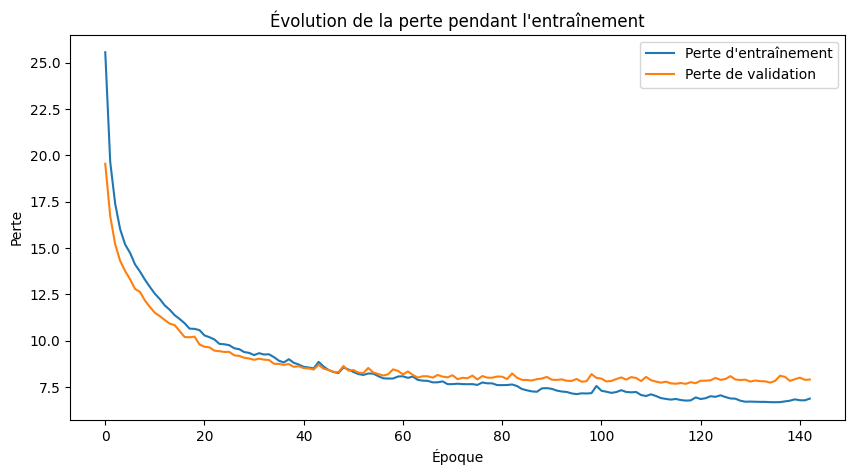

In [30]:
# **Tracer les courbes de perte**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


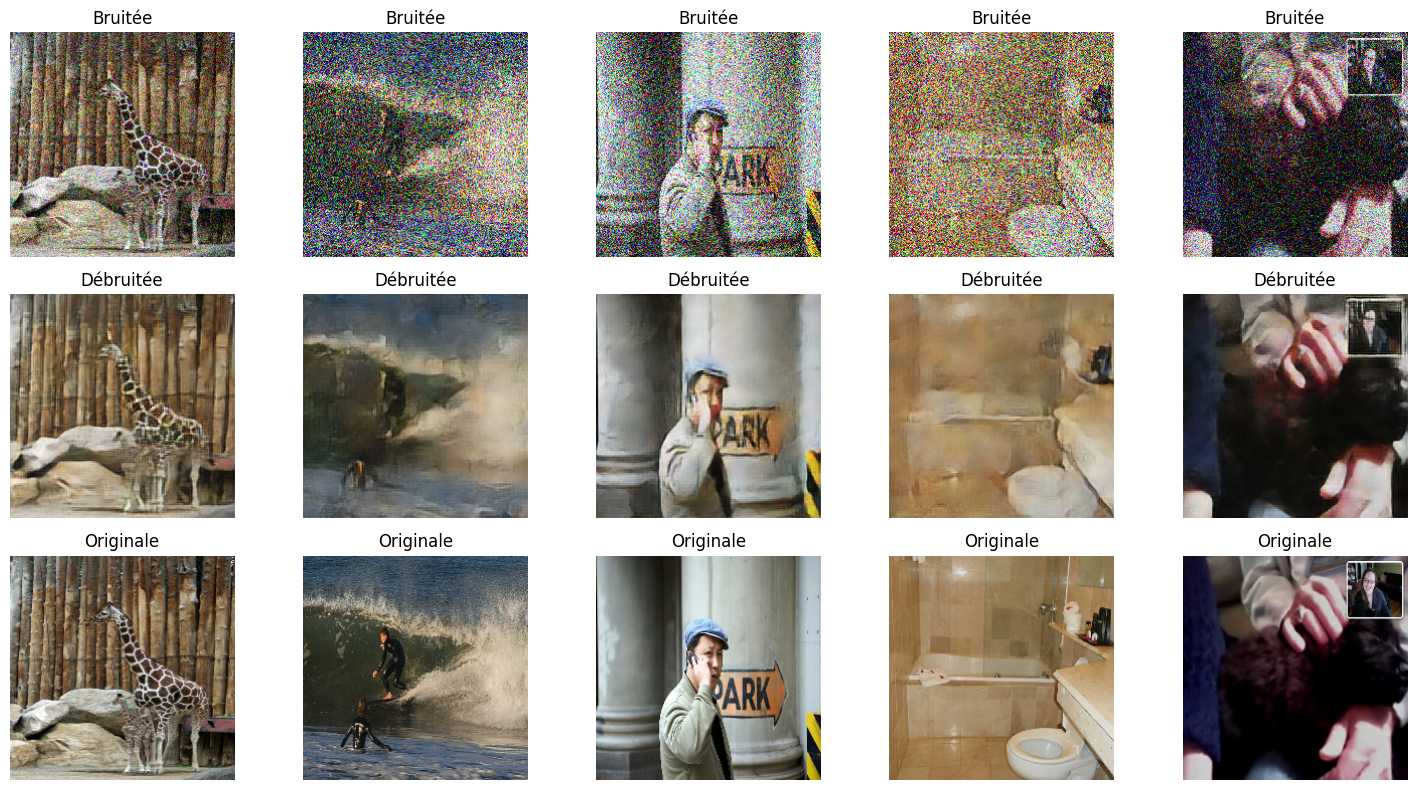

In [31]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Prédire les images débruitées
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # **Image bruitée**
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')
            
            # **Image débruitée**
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Débruitée')
            plt.axis('off')
            
            # **Image originale**
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# **Affichage des résultats**
display_denoised_images(autoencoder, noisy_test_set, num_images=5)